In [1]:
# %load_ext nb_black

# Ultimate Data Challenge

## Part 1 - Exploratory data analysis

### Data Quality

The only significant data quality issue relates to the start and stop times on the first and last day of the observations.  The start time was Thursday, January 1st, 1970 at 20:12:16.  No logins prior to 20:12:16 were recorded.  The end time was Monday, April 13th at 18:57:38.  No logins after 18:57:38 were recorded.  The data for these two incomplete dates was removed for this analysis.

### Patterns and features of the demand

There are a few noticeable demand patterns:

 - Weekday demand is lowest on Mondays and increases throughout the week (Figure 1)
 - Weekends (including Friday night) are consistently busier than weekdays (Figure 1 & 2)
 - Weekends have a spike of activity on Friday night, Saturday morning and Sunday morning (Figure 2)
 - Weekdays have a less exaggerated spike beginning around 10am and lasting until about 2pm (Figure 2)
 - Weekdays between 6am and 9am have the lowest demand (Figure 2)
 - There was a spike of demand beginning ~March 16 and ending ~March 19.  Possibly a large event in town... (Figure 1 & 3)

![title](images/Figure_1.png)
***
![title](images/Figure_2.png)
***
![title](images/Figure_3.png)



## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key metric of success is a shift from per city revenue for each driver partner from their current proportion of fares (e.g. hypothetically 80% city of preference, 20% other city) towards 50% (e.g.  60% city of preference, 20% other city).  The objective of having driver partners to be available in both cities (as opposed to current state of mostly once city) would directly correlate with the percentage of revenues decreasing for the city of preference while increasing for the other city.  No matter what other easily obtainable metric you choose, if they are not generating revenue from the other city, the change will only be temporary.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    - how you will implement the experiment
    - what statistical test(s) you will conduct to verify the significance of the observation
    - how you would interpret the results and provide recommendations to the city operations team along with any caveats.

I would pick a timeframe that corresponds to the city's taxing period / driver partner reporting period, probably 1 month.  Since each driver partner is required to report city revenues, on control period is preexisting which is a significant benefit.  During the no toll month, I would eliminate all toll fares for on duty driver partners. Eliminating the fares is far more financially efficient then reimbursing the fares as well as providing immediate gratification to the driver partner resulting in a faster adoption of the cities objective of having the driver partner serving both cities. It would be important that a marketing campaign be in place to ensure all driver partner were aware of the elimination of the toll for the month.  I would then compare each driver partners monthly reporting to determine if the revenue was more equally distributed between the two cities and if the overall revenue had increased. A sample t-test could be utilized to determine changes discussed.  Finally, by comparing the increase (decreased) revenue from driver partner city taxes and loss in toll revenue, it would be easy to calculate the net tangible financial impact.  The administrative costs of this program would be minimal.  The financial impact would than need to be compared to the nontangible impacts including shorter wait times, more effective movement of people, ability to lure big events to the city, reduction of cars because of people relying on driver partners...

## Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.


We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.


The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

Standard cleaning was performed on the data including converting dates to ordinal, filling in missing values with column averages, populating missing data in phone, calculating the retained field, and one hot encoding the phone and city fields.  100% of the data was retained because the missing data was easy to account for and not significant.

All the users were signed up in January and the last trip registered was on July 1st.  For calculating retained users (trip in last 30 days), I used July 1st as the date of the analysis.

37.61% of the users were retained.

I reviewed the following correlation matrix to help understand the relationships between the fields.

![title](images/sns_corr.png)

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

This is a binary classification problem - active user *or* not active user.  The data was split into 72% training, 18% validation and 10% test (holdout).  I ran one iteration over 11 popular classification models to and LightGBM performed the best and, although not the fastest, ran reasonable fast.  The model performed at 78.9% accuracy (utilizing hyperopt to optimize features).  One concern is the model was more successful at predicting inactive users (negatives) than active users (positives).  Changes to metrics that optimize active users (positives) might be beneficial.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

- King's landing is very correlated with active users but the other two cities are negatively correlated.  Identifying the cause of this difference would be beneficial and potentially increase active users.
- iPhone is very correlated with active users while Android is very negatively correlated with active users.  Are there problems with the Android app?  Does the iPhone app have features not available in the Android app?
- Ultimate black users are positively correlated with active users.  Promotions to encourage riders to try ultimate black could be advantageous.

Housekeeping

In [2]:
import numpy as np
import json
import time
import calendar
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
pd.options.mode.chained_assignment = None

%matplotlib inline

In [3]:
DATA_DIR = Path.cwd()

In [4]:
def save_obj(obj, name):
    import pickle
    with open(DATA_DIR / str(name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name ):
    import pickle
    with open(DATA_DIR / str(name + '.pkl'), 'rb') as f:
        return pickle.load(f)

    
def bl(qty=1):
    for l in range(qty):
        print()

# Part 1 code

Reading and cleaning data

In [5]:
df_second = pd.read_json('logins.json')
df_second.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
df_second.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [7]:
df_second.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [8]:
# confirm no missing dates (calendar dates) in original data
cal_dates = np.sort(df_second['login_time'].dt.date.unique())
start_date, end_date = cal_dates.min(), cal_dates.max()
serial_cal_dates = np.arange(start_date, end_date + pd.Timedelta(days=1), timedelta(days=1)).astype(datetime)
serial_cal_dates = np.array([x.date() for x in serial_cal_dates])
if np.array_equal(cal_dates, serial_cal_dates):
    print(f'No missing dates')
else:
    print(f'WARNING - missing dates')

No missing dates


In [9]:
print(df_second['login_time'].min())
print(df_second['login_time'].max())

1970-01-01 20:12:16
1970-04-13 18:57:38


The login data begins at 8:12pm on 01-01-1970 and ends at 6:57pm on 04-13-1970.  Both partial days are being removed for this analysis.

In [10]:
delete_rows = df_second[df_second['login_time'] < '19700102'].index
df_second = df_second.drop(delete_rows)
delete_rows = df_second[df_second['login_time'] > '19700413'].index
df_second = df_second.drop(delete_rows)

Sum the number of login_times by day

In [11]:
df_1D = df_second.resample('1D', on='login_time').count().rename(columns={'login_time': 'count'})
df_1D.index.set_names('login_date', inplace=True)
df_1D.reset_index(inplace=True)
df_1D['login_date'] = pd.to_datetime(df_1D['login_date'])
df_1D['day_of_week'] = df_1D['login_date'].dt.dayofweek
df_1D['day_name'] = df_1D['login_date'].dt.day_name().str[0:3]
df_1D['week_no'] = df_1D['login_date'].dt.week

Visualize the daily login informaiton.

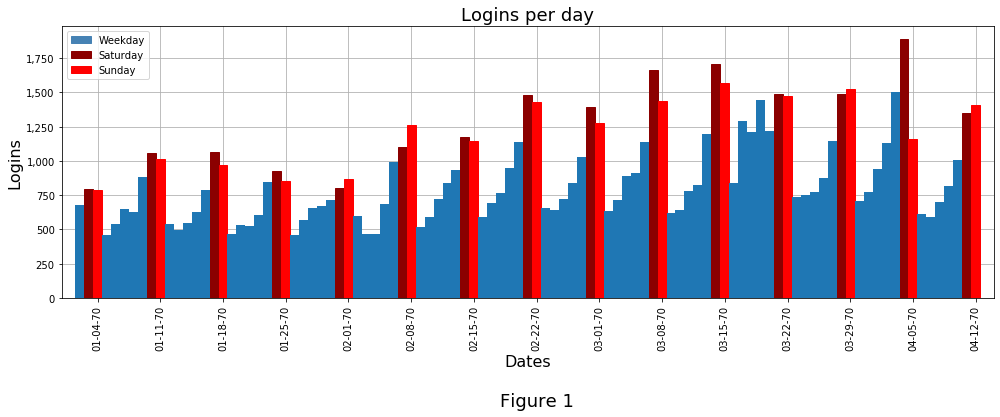

In [12]:
tick_spacing=7  # show one tick per week (7 days)
fig, ax = plt.subplots(figsize=(14,6))
x = df_1D['login_date']
y = df_1D['count']
plt.grid()  # show grid and place behind bars
ax.set_axisbelow(True)
bars = ax.bar(x, y, width=1)

# adjust for easy viewing
plt.title('Logins per day', fontsize=18)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_major_formatter(DateFormatter('%m-%d-%y'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.margins(x=100)
plt.xlim([min(x)- pd.Timedelta(days=2), max(x)+ pd.Timedelta(days=2)])

plt.ylabel('Logins', fontsize=16)
plt.xlabel('Dates', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(bottom=0.3) 
fig.text(.5, .05, 'Figure 1', ha='left', fontsize=18)

# highlight saturdays and sundays
for item in bars[2::7]:
    item.set_color('red')
for item in bars[1::7]:
    item.set_color('darkred')

# create and show legend
blue_patch = mpatches.Patch(color='steelblue', label='Weekday')
darkred_patch = mpatches.Patch(color='darkred', label='Saturday')
red_patch = mpatches.Patch(color='red', label='Sunday')

plt.legend(handles=[blue_patch, darkred_patch, red_patch])

bl()
plt.savefig('Figure_1.png')
plt.show()
bl(2)

In [13]:
# summarize in 15 minute increments
df_15T = df_second.resample('15T', on='login_time').count().rename(columns={'login_time': 'count'})
df_15T.index.set_names('login_time', inplace=True)
df_15T.reset_index(inplace=True)
df_15T['login_time'] = pd.to_datetime(df_15T['login_time'])
df_15T['day_of_week'] = df_15T['login_time'].dt.dayofweek
df_15T['day_name'] = df_15T['login_time'].dt.day_name().str[0:3]
df_15T['str_login_time'] = df_15T['login_time'].dt.strftime('%T')
df_15T['login_date'] = df_15T['login_time'].dt.date
# average each 15min by day of week
df_15T_weekday_average=pd.DataFrame(df_15T[['day_of_week','str_login_time','count']].groupby(['day_of_week','str_login_time']).mean()).reset_index()
# df_15T_weekday_average.head()

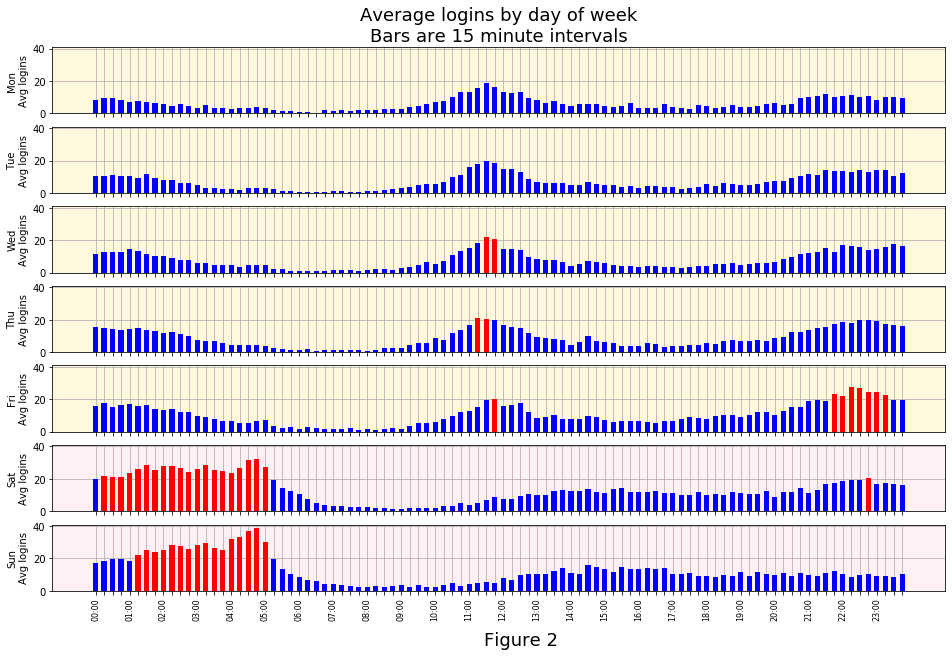

In [14]:
# plot
fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(16,10), sharex=True, sharey=True)
axs[0].set_title('Average logins by day of week\nBars are 15 minute intervals', fontsize=18)
back_color = ['cornsilk','cornsilk','cornsilk','cornsilk','cornsilk','lavenderblush', 'lavenderblush']

for c, ax in enumerate(axs):
    x = df_15T_weekday_average[df_15T_weekday_average['day_of_week']==c]['str_login_time'].reset_index(drop=True)
    x = [z[0:5] for z in x] # remove seconds
    y = df_15T_weekday_average[df_15T_weekday_average['day_of_week']==c]['count'].reset_index(drop=True)
    bars = ax.bar(x, y, width=.6, color=(y > 20).map({True:'r', False:'b'}))
for c, ax in enumerate(axs.flat):
    ax.grid()  # show grid and place behind bars
    ax.set_facecolor(back_color[c])
    ax.set_axisbelow(True)
    ax.set(ylabel = calendar.day_abbr[c] + '\nAvg logins') # day_name for full name
# x-labels only on last plot
plt.xticks(range(len(x)), x, horizontalalignment='center')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8);
fig.text(.5, .05, 'Figure 2', ha='left', fontsize=18)

# show only hours (a bit of a hack but works)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
plt.savefig('Figure_2.png')
plt.show();

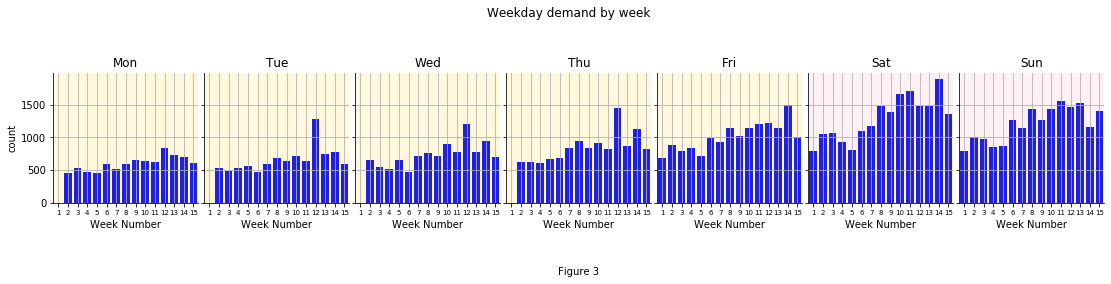

In [15]:
# plot
back_color = ['cornsilk','cornsilk','cornsilk','cornsilk','cornsilk','lavenderblush', 'lavenderblush']
axs = sns.catplot(x='week_no', y='count', col='day_name', col_order=calendar.day_abbr , data=df_1D, kind='bar', col_wrap=7, legend=False, color='blue');
axs.fig.set_size_inches(15,4)
axes = axs.axes.flatten()
plt.subplots_adjust(top=.75)
axs.fig.suptitle('Weekday demand by week')
plt.subplots_adjust(bottom=.3) 
axs.fig.text(.49, .05, 'Figure 3', ha='left')
for c, ax in enumerate(axes):
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 7)
    ax.set_title(calendar.day_abbr[c])
    ax.set_xlabel('Week Number')
    ax.grid(True)
    ax.set_facecolor(back_color[c])

bl()
plt.savefig('Figure_3.png')
plt.show();
bl(2)

# Part 3 code

Housekeeping

In [16]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC, NuSVC
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    SCORERS,  # # sorted(SCORERS.keys())
    confusion_matrix,
    plot_confusion_matrix,
    roc_curve
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import (
    QuadraticDiscriminantAnalysis,
    LinearDiscriminantAnalysis,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

In [17]:
# Algorithms to try
classification_algos_name = [
    "KNeighborsClassifier",
    "GaussianNB",
    "MultinomialNB",
    "DecisionTreeClassifier",
    "ExtraTreeClassifier",
    "LinearDiscriminantAnalysis",
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier",
    "XGBClassifier",
    "LGBMClassifier",
]

classification_algos = [
    KNeighborsClassifier(),
    GaussianNB(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    LinearDiscriminantAnalysis(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
]

In [18]:
# helper function - plot confusion matrix
def plot_cm(truth, prediction, cmap='Blues', font_scale=1.4):
    cf_matrix = confusion_matrix(truth, prediction)
    sns.set(font_scale=font_scale)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0,.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=cmap);

Read and clean data

In [19]:
df_ultimate = pd.read_json('ultimate_data_challenge.json')
df_ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
df_ultimate['last_trip_date'].max()

'2014-07-01'

In [21]:
df_ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [22]:
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [23]:
df_ultimate.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [24]:
# convert signup date to ordinal
df_ultimate['signup_date'] = pd.to_datetime(df_ultimate['signup_date'].astype('datetime64[ns]'))
df_ultimate['signup_date'] = df_ultimate['signup_date'].map(datetime.toordinal)


# calculate retained field based on last_trip_date and convert last_trip_date to ordinal
df_ultimate['last_trip_date'] = pd.to_datetime(df_ultimate['last_trip_date'].astype('datetime64[ns]'))
retained_window = df_ultimate['last_trip_date'].max() - pd.Timedelta(days=30)
df_ultimate['retained'] = df_ultimate['last_trip_date'] >= retained_window
df_ultimate.drop(['last_trip_date'], axis=1, inplace=True)

# fill na data with averages
df_ultimate['avg_rating_of_driver'].fillna(df_ultimate['avg_rating_of_driver'].mean(), inplace=True)
df_ultimate['avg_rating_by_driver'].fillna(df_ultimate['avg_rating_by_driver'].mean(), inplace=True)

# populate blank phone type data
df_ultimate['phone'].fillna('Generic', inplace=True)

print(f'To be active, user must have taken a trip on or after {retained_window.strftime("%m/%d/%Y")}.')
bl()
print(f'{"Retained customers:":<33} {df_ultimate["retained"].sum():,.0f}')
print(f'{"Total customers:":<33} {df_ultimate["retained"].count():,.0f}')
print(f'{"Percent of Retained customers:":<34} {((df_ultimate["retained"].sum()) / (df_ultimate.shape[0])):.2%}')
df_ultimate = df_ultimate.reindex(sorted(df_ultimate.columns), axis=1)
df_ultimate.head()

To be active, user must have taken a trip on or after 06/01/2014.

Retained customers:               18,804
Total customers:                  50,000
Percent of Retained customers:     37.61%


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,retained,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,True,735258,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,Android,False,735262,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,False,735239,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,True,735243,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,False,735260,11.8,14,False,82.4


In [25]:
cat_cols = df_ultimate.select_dtypes(include=['object']).columns
print(f'Catagorical columns: {cat_cols}')
for col in cat_cols:
    dummies = pd.get_dummies(df_ultimate[col]).rename(columns=lambda x:  col + '_' + str(x))
    df_ultimate = pd.concat([df_ultimate, dummies], axis=1)
    df_ultimate.drop([col], inplace=True, axis=1)
df_ultimate.head()

Catagorical columns: Index(['city', 'phone'], dtype='object')


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,retained,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Generic,phone_iPhone
0,3.67,5.0,4.7,1.10,True,735258,15.4,4,True,46.2,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,False,735262,0.0,0,False,50.0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,False,735239,0.0,3,False,100.0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,True,735243,20.0,9,True,80.0,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,False,735260,11.8,14,False,82.4,0,0,1,1,0,0


In [26]:
print(f'Coorelation with retained')
df_ultimate.corr(method ='pearson') ['retained'].sort_values(ascending=False)[1:]

Coorelation with retained


city_King's Landing       0.262284
phone_iPhone              0.225244
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
phone_Generic            -0.007419
avg_rating_of_driver     -0.010829
signup_date              -0.020211
avg_rating_by_driver     -0.026748
city_Winterfell          -0.046611
avg_dist                 -0.092780
city_Astapor             -0.174655
phone_Android            -0.225464
Name: retained, dtype: float64

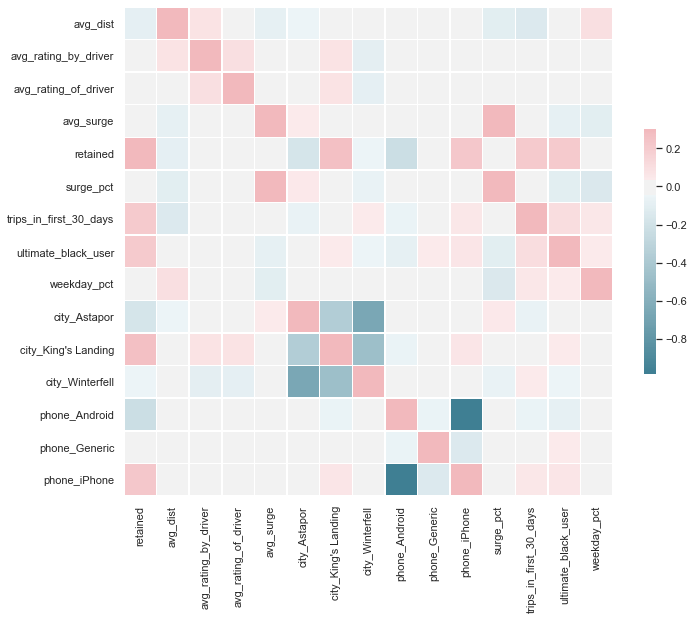

In [27]:
sns.set(style="white")

# Compute the correlation matrix
df_corr = df_ultimate.corr()
first_col = 'retained'
df_corr = df_corr.reindex(columns=sorted(df_corr.columns))
df_corr = df_corr.reindex(columns=([first_col] + list([a for a in df_corr.columns if a != first_col]) ))
df_corr.drop('signup_date', inplace=True, axis=0)
df_corr.drop('signup_date', inplace=True, axis=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(df_corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
g.figure.savefig("sns_corr.png")

In [28]:
# split the data
X = df_ultimate.drop("retained", axis=1)
y = df_ultimate["retained"]

X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(
    X, y, test_size=0.1, random_state=50, stratify=y
)
# Separate remainder into training and validation data for optimization
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_and_valid,
    y_train_and_valid,
    test_size=0.2,
    random_state=50,
    stratify=y_train_and_valid,
)

print(f'{"Total Data:":<28}{X.shape[0]:7,.0f}{1:6.0%}  {"X"}')
bl()
print(f'{"Test (holdout) data:":<28}{X_test.shape[0]:7,.0f}{.1:6.0%}  {"X_test"}')
print(
    f'{"Train and Validation data:":<28}{X_train_and_valid.shape[0]:7,.0f}{.9:6.0%}  {"X_train_and_valid"}'
)
bl()
print(f'{"Train data:":<28}{X_train.shape[0]:7,.0f}{.72:6.0%}  {"X_train"}')
print(f'{"Validation data:":<28}{X_valid.shape[0]:7,.0f}{.18:6.0%}  {"X_valid"}')

Total Data:                  50,000  100%  X

Test (holdout) data:          5,000   10%  X_test
Train and Validation data:   45,000   90%  X_train_and_valid

Train data:                  36,000   72%  X_train
Validation data:              9,000   18%  X_valid


In [29]:
accuracy_score_list = []
f1_score_list = []
precision_score_list = []
recall_score_list = []
roc_auc_score_list = []

print(
    f'{"classsifier":<30} {"accuracy":<6}  {"f1_score":<6}  {"precision":<7}    {"recall":<6}   {"roc_auc":<6}  {"time":<15}'
)


for idx, mod in enumerate(classification_algos):
    start = time.time()
    model = mod
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    end = time.time()
    recall_score_list.append(recall_score(y_valid, y_valid_pred))
    precision_score_list.append(precision_score(y_valid, y_valid_pred))
    f1_score_list.append(f1_score(y_valid, y_valid_pred))
    accuracy_score_list.append(accuracy_score(y_valid, y_valid_pred))
    roc_auc_score_list.append(roc_auc_score(y_valid, y_valid_pred))

    print(
        f"{classification_algos_name[idx]:<30} {accuracy_score_list[idx]:>8.2%}  {f1_score_list[idx]:>8.2%}  {precision_score_list[idx]:>9.2%}  {recall_score_list[idx]:>8.2%}  {roc_auc_score_list[idx]:>8.2%}  {end-start:.2f} sec"
    )

classsifier                    accuracy  f1_score  precision    recall   roc_auc  time           
KNeighborsClassifier             72.56%    61.95%     64.72%    59.41%    69.95%  1.00 sec
GaussianNB                       69.93%    64.05%     58.19%    71.23%    70.19%  0.05 sec
MultinomialNB                    65.89%    50.18%     55.67%    45.67%    61.87%  0.05 sec
DecisionTreeClassifier           70.64%    61.02%     60.95%    61.09%    68.75%  0.21 sec
ExtraTreeClassifier              69.86%    59.66%     60.06%    59.26%    67.75%  0.06 sec
LinearDiscriminantAnalysis       71.44%    55.21%     67.32%    46.79%    66.55%  0.12 sec
RandomForestClassifier           77.22%    68.40%     71.51%    65.55%    74.91%  3.39 sec
AdaBoostClassifier               77.22%    68.03%     72.05%    64.43%    74.68%  2.28 sec
GradientBoostingClassifier       78.02%    69.28%     73.04%    65.88%    75.61%  3.40 sec
XGBClassifier                    78.00%    69.29%     72.94%    66.00%    75.62%  1

In [30]:
from bokeh.io import output_notebook

data = pd.DataFrame(
    {"algorithms": classification_algos_name, "accuracy_score": accuracy_score_list}
)
data["color"] = [
    "#440154",
    "#404387",
    "#29788E",
    "#22A784",
    "#79D151",
    "#FDE724",
    "#30678D",
    "#084594",
    "#2171b5",
    "#4292c6",
    "#9ecae1",
]
output_notebook()

Loading BokehJS ...

In [31]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap

source = ColumnDataSource(data=data)

p = figure(
    x_range=data["algorithms"],
    y_range=(0.6, 0.8),
    plot_width=400,
    plot_height=300,
    title="Comparison",
    tools="hover",
    tooltips="@algorithms: @accuracy_score",
)
p.vbar(x="algorithms", top="accuracy_score", color="color", width=0.95, source=source)

p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = 120
show(p)

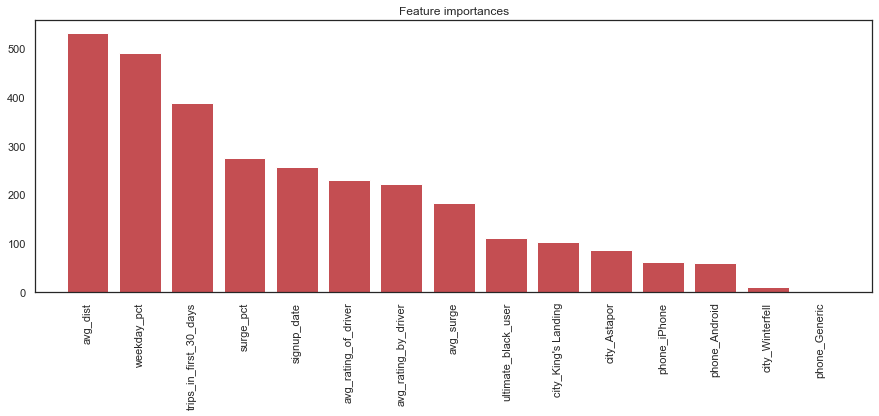

In [32]:
def feat_imp(df, model, n_features):
    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]
    plt.figure(figsize=(15, 5))
    plt.title("Feature importances")
    plt.bar(range(n_features), [d[i] for i in top_names], color="r", align="center")
    plt.xlim(-1, n_features)
    plt.xticks(range(n_features), top_names, rotation="vertical")

feat_imp(X_train, model, 15)

In [33]:
import lightgbm as lgb

params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "binary",
    "learning_rate": 0.01,
    "metric": ["binary_error"],
}
data_all = lgb.Dataset(X_train, y_train)

results = lgb.cv(
    params,
    train_set=data_all,
    nfold=5,
    seed=10,
    stratified=True,
    num_boost_round=1000
)

print(f'LGBM\'s cv binary_error: {results["binary_error-mean"][-1]:.2%}')

LGBM's cv binary_error: 20.94%


In [34]:
def lgbm_hyperopt(X_vaild, y_valid):
    from hyperopt.pyll.base import scope
    from hyperopt import hp, tpe, Trials, space_eval
    from hyperopt.fmin import fmin
    from sklearn.model_selection import (
        cross_val_score,
        StratifiedKFold,
        train_test_split,
    )
    from sklearn.preprocessing import MinMaxScaler

    Y_valid = np.array(y_valid)
    Y_valid = Y_valid.ravel()

    def objective(params):
        params = {
            "n_estimators": int(params["n_estimators"]),
            "learning_rate": params["learning_rate"],
            "num_leaves": int(params["num_leaves"]),
            "subsample": round(params["subsample"], 2),
            "colsample_bytree": round(params["colsample_bytree"], 2),
            "reg_alpha": round(params["reg_alpha"], 2),
            "reg_lambda": round(params["reg_lambda"], 2),
        }
        clf = lgb.LGBMClassifier(
            objective="binary",
            boosting_type="gbdt",  # dart for better accuracy (slow) 'gbdt'
            max_depth=-1,  # max depth, shallower trees reduce overfitting.
            max_bin=500,  # maximum number of bins to bucket feature values in
            subsample_freq=15,
            silent=False,
            metrics="None",
            verbose=1,
            n_jobs=-1,
            **params,
        )
        score = cross_val_score(clf, X_vaild, Y_valid, scoring='roc_auc', cv=StratifiedKFold(n_splits=3)).mean()
#         print("Score: {:.3f} params {}".format(score, params))
        return {"loss": -score, "status": "ok", "model": model}

    space = {
        "n_estimators": hp.uniformint("n_estimators", 30, 300),
        "learning_rate": scope.float(hp.choice("learning_rate", [0.1, 0.01, 0.001])),
        "num_leaves": scope.int(hp.quniform("num_leaves", 30, 300, 10)),
        "subsample": hp.quniform(
        "subsample", 0.7, 1, 0.05),  # fraction of training rows used in each tree
        "colsample_bytree": hp.quniform("colsample_bytree", 0.7, 1, 0.05),
        "reg_alpha": hp.quniform("reg_alpha", 0, 0.2, 0.05),
        "reg_lambda": hp.quniform("reg_lambda", 0, 0.2, 0.05),
    }
    trials = Trials()  # for logging
    algo = tpe.suggest  # Tree of Parzen Estimators (a "Bayesian" method)
    best = fmin(
        fn=objective,
        space=space,
        algo=algo,  # optimization algorithm
        trials=trials,  # logging
        max_evals=500,
    )
    hyperparams = space_eval(space, best)  # fixes rounding on learning rate
    save_obj(hyperparams, "params")  
    bl()
    print(f"Hyperopt estimated optimum  {hyperparams}")
    bl(2)
    return trials, best

hyperparams, best = lgbm_hyperopt(X_valid, y_valid)

100%|████████████████████████████████████████████████| 500/500 [29:41<00:00,  3.56s/it, best loss: -0.8454851813239475]

Hyperopt estimated optimum  {'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.01, 'n_estimators': 300, 'num_leaves': 40, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'subsample': 1.0}




Best paramaters: {'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.01, 'n_estimators': 300, 'num_leaves': 40, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'subsample': 1.0}


LGBM validation final results:
   Accuracy score: 77.98%
   Roc_auc score:  75.32%




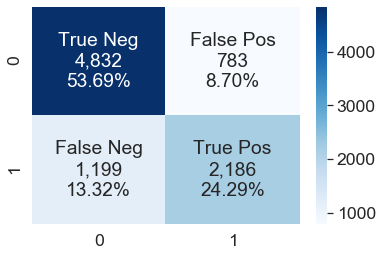

In [35]:
params = load_obj("params")
print(f"Best paramaters: {params}")
bl()
clf = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    num_boosting_round=100,
    max_depth=-1,
    max_bin=500,
    subsample_freq=15,
    random_state=94,
    metric='roc_auc',
    verbose=0,
    n_jobs=-1,
    **params,
)
clf.fit(
    X_train,
    y_train,
    categorical_feature="auto",
    verbose=-1,
)

y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration_)
bl()
print(f"LGBM validation final results:")
print(f"   Accuracy score: {accuracy_score(y_valid, y_pred):.2%}")
print(f"   Roc_auc score:  {roc_auc_score(y_valid, y_pred):.2%}")
bl()
plot_cm(truth=y_valid, prediction=y_pred, cmap='Blues', font_scale=1.6)
# plot_confusion_matrix(clf, X_valid, y_valid, normalize='true', values_format='.2f', cmap=plt.cm.Greens_r,)
bl()


Best paramaters: {'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.01, 'n_estimators': 300, 'num_leaves': 40, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'subsample': 1.0}



LGBM test (holdout) final results: TN:2,738  FP:382  FN:673  TP:1,207  Total:5,000

Accuracy score: 78.90%
Roc_auc score:  75.98%




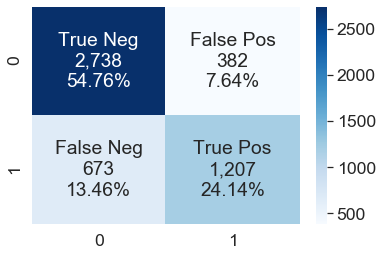

In [36]:
print(f"Best paramaters: {params}")
bl()
clf2 = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    max_depth=-1,
    max_bin=500,
    subsample_freq=15,
    random_state=94,
    metric='roc_auc',
    verbose=-1,
    n_jobs=-1,
    **params,
)
clf2.fit(
    X_train_and_valid,
    y_train_and_valid,
    categorical_feature="auto",
    verbose=-1,
)

y_pred = clf2.predict(X_test, num_iteration=clf.best_iteration_)
bl(2)

cm = confusion_matrix(y_test, y_pred).ravel()
print(
    f"LGBM test (holdout) final results: TN:{cm[0]:,}  FP:{cm[1]:,}  FN:{cm[2]:,}  TP:{cm[3]:,}  Total:{cm[1] + cm[2] + cm[3] + cm[0]:,}"
)
bl()
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2%}")
print(f"Roc_auc score:  {roc_auc_score(y_test, y_pred):.2%}")
bl()

plot_cm(truth=y_test, prediction=y_pred, cmap='Blues', font_scale=1.6)
bl()